In [118]:
# Import Statements
import numpy as np
import matplotlib.pyplot as plt
from qutip import basis, Qobj, mesolve
from quantum_logical.operators import selective_destroy

In [2]:
from itertools import product

# Define the possible values for each pipe
A_options = range(0, 6)  # 0 to 5
BCD_options = [5, 10]  # 5 or 10


# Brute force search
def find_configurations():
    configurations = []

    for A, B, C, D in product(A_options, BCD_options, BCD_options, BCD_options):
        for weighted_pipe in ["B", "C", "D"]:
            # Calculate the total water used and the total points
            total_water = A + B + C + D
            total_points = (
                (5 * A if weighted_pipe == "A" else A)
                + (5 * B if weighted_pipe == "B" else B)
                + (5 * C if weighted_pipe == "C" else C)
                + (5 * D if weighted_pipe == "D" else D)
            )

            # Check if the configuration meets the criteria
            if total_water == 17 and total_points == 28:
                configurations.append(
                    {"A": A, "B": B, "C": C, "D": D, "Weighted": weighted_pipe}
                )

    return configurations


# Find and display the configurations
configurations = find_configurations()
configurations

[]

In [119]:
# Function Definitions
def logistic_function(t, k, t0):
    return 1 / (1 + np.exp(-k * (t - t0)))


def Ha_coeff(t, args):
    return (1 - logistic_function(t, args["k_a"], args["t0_a"])) * np.pi / 2


def Hb_coeff(t, args):
    return logistic_function(t, args["k_b"], args["t0_b"]) * np.pi / 2


def Ha_coeff_non_adiabatic(t, args):
    return 1 * np.pi / 2 if t < args.get("t_switch", 5) else 0


def Hb_coeff_non_adiabatic(t, args):
    return 1 * np.pi / 2 if t >= args.get("t_switch", 5) else 0


def time_dependent_H(t, adiabatic=True):
    if adiabatic:
        return Ha * Ha_coeff(t, coeff_args) + Hb * Hb_coeff(t, coeff_args)
    else:
        return Ha * Ha_coeff_non_adiabatic(t, coeff_args) + Hb * Hb_coeff_non_adiabatic(
            t, coeff_args
        )

In [120]:
# Parameters and Hamiltonian Initialization
coeff_args = {"k_a": 5, "t0_a": 7, "k_b": 5, "t0_b": 5}
tlist = np.linspace(0, 10, 100)
Ha = selective_destroy(3, 1, 0) + selective_destroy(3, 1, 0).dag()
Hb = selective_destroy(3, 2, 1) + selective_destroy(3, 2, 1).dag()
H = [[Ha, Ha_coeff], [Hb, Hb_coeff]]
rho0 = basis(3, 0) * basis(3, 0).dag()

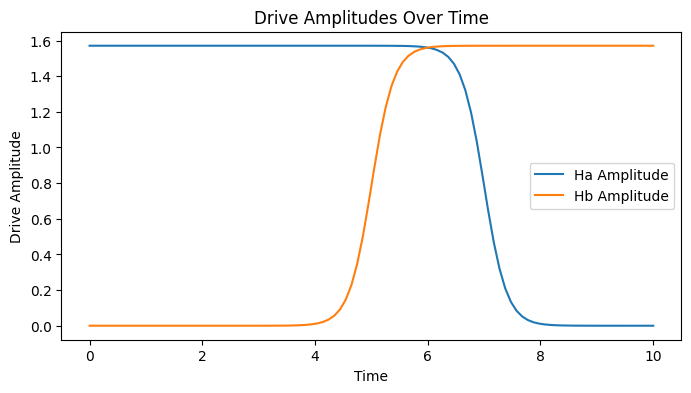

In [121]:
# Plot Drive Amplitudes Over Time
plt.figure(figsize=(8, 4))
plt.plot(tlist, [Ha_coeff(t, coeff_args) for t in tlist], label="Ha Amplitude")
plt.plot(tlist, [Hb_coeff(t, coeff_args) for t in tlist], label="Hb Amplitude")
plt.xlabel("Time")
plt.ylabel("Drive Amplitude")
plt.title("Drive Amplitudes Over Time")
plt.legend()
plt.show()

In [122]:
# Compute Eigenvalues for Both Scenarios
eigenvalues_adiabatic = np.array(
    [Qobj(time_dependent_H(t)).eigenenergies() for t in tlist]
)
eigenvalues_non_adiabatic = np.array(
    [Qobj(time_dependent_H(t, adiabatic=False)).eigenenergies() for t in tlist]
)

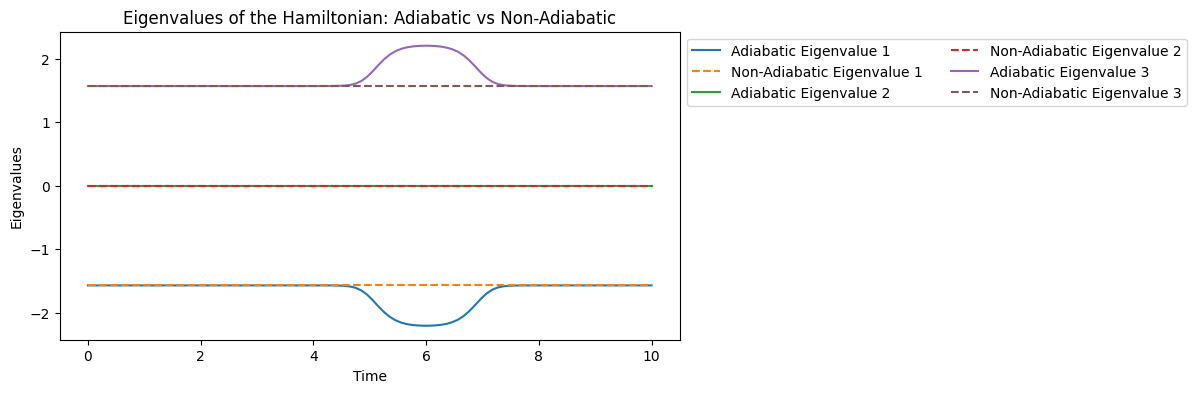

In [123]:
# Plotting
plt.figure(figsize=(8, 4))
for i in range(eigenvalues_adiabatic.shape[1]):
    plt.plot(tlist, eigenvalues_adiabatic[:, i], label=f"Adiabatic Eigenvalue {i+1}")
    plt.plot(
        tlist,
        eigenvalues_non_adiabatic[:, i],
        "--",
        label=f"Non-Adiabatic Eigenvalue {i+1}",
    )
plt.xlabel("Time")
plt.ylabel("Eigenvalues")
plt.title("Eigenvalues of the Hamiltonian: Adiabatic vs Non-Adiabatic")
plt.legend(ncols=2, bbox_to_anchor=(1, 1))
plt.show()

In [124]:
# Solving the time-dependent Schrödinger equation
output = mesolve(H, rho0, tlist, args=coeff_args)

In [125]:
output

Result object with mesolve data.
--------------------------------
states = True
num_collapse = 0